In [74]:
import torch
import torch.nn as nn
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import math
import os, sys
from tqdm import tqdm
import random

from denoising_diffusion_pytorch import GaussianDiffusion
from denoising_diffusion_pytorch.denoising_diffusion_pytorch import SinusoidalPosEmb

In [92]:
class OneDModel(torch.nn.Module):
    def __init__(self, dim = 16, **kw):
        super().__init__(**kw)
        self.channels = self.out_dim = 1
        self.self_condition = False
        time_dim = dim * 4

        sinu_pos_emb = SinusoidalPosEmb(dim)
        
        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, dim)
        )
        
        self.main = torch.nn.ModuleList([
            torch.nn.Linear(1, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, dim),
            torch.nn.GELU(),
            torch.nn.Linear(dim, 1)
        ])
        
    def forward(self, x_t, t, self_cond=None):
        """ x: (batsize, 1, 1, 1)"""
        x_t = x_t.squeeze(-1).squeeze(-1)
        
        temb = self.time_mlp(t)
        
        h = self.main[0](x_t)
        h = h + temb
        for layer in self.main[1:]:
            h = layer(h)
            
        h = h[:, :, None, None]
        return h

In [93]:
m = OneDModel()
x = torch.randn((5,1, 1, 1))
t = torch.rand((5,))
print(x, t)

y = m(x, t)
print(y)

tensor([[[[-0.8151]]],


        [[[ 0.4265]]],


        [[[-2.3414]]],


        [[[-0.1745]]],


        [[[-0.0328]]]]) tensor([0.4725, 0.7170, 0.4406, 0.3731, 0.4615])
tensor([[[[-0.0830]]],


        [[[-0.0906]]],


        [[[-0.0724]]],


        [[[-0.0879]]],


        [[[-0.0888]]]], grad_fn=<UnsqueezeBackward0>)


In [94]:
diffusion = GaussianDiffusion(model=m, image_size=1, timesteps=100, loss_type="l2")

In [100]:
class OneDDataset(torch.utils.data.Dataset):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.peaks = [-3, -2, 2, 3]
        self.var = 0.05
        
    def __getitem__(self, i):
        # randomly choose one of the peaks
        ret = random.choice(self.peaks)
        ret = ret + random.gauss(0, self.var)
        return torch.tensor([ret])[:, None, None]
        
    def __len__(self):
        return 10000
    
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

In [101]:
ds = OneDDataset()
dl = torch.utils.data.DataLoader(ds, batch_size=128)

print(len(ds))
samples = [x[0, 0, 0] for x in ds]

10000


(array([6.45800964e-02, 6.45800964e-01, 1.74996967e+00, 1.28057606e+00,
        2.01615911e-01, 1.41761187e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.15024861e-03,
        1.22859696e-01, 9.35627350e-01, 1.89644966e+00, 9.46649706e-01,
        1.16559198e-01, 3.15025452e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

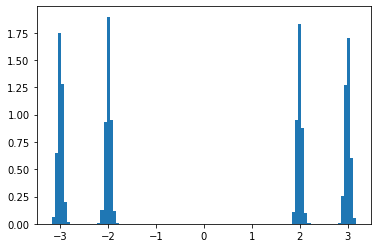

In [102]:
plt.hist(samples, density=True, bins=100)

In [103]:
print(next(iter(dl)))

tensor([[[[-1.9713]]],


        [[[ 1.9722]]],


        [[[-2.9564]]],


        [[[ 2.1035]]],


        [[[-3.0913]]],


        [[[ 1.9144]]],


        [[[ 1.9837]]],


        [[[-1.9785]]],


        [[[-1.9306]]],


        [[[ 3.0437]]],


        [[[ 3.0342]]],


        [[[-2.9603]]],


        [[[ 3.0607]]],


        [[[ 1.9920]]],


        [[[ 1.9464]]],


        [[[-1.9937]]],


        [[[-1.9368]]],


        [[[ 1.9184]]],


        [[[ 3.0329]]],


        [[[-3.0150]]],


        [[[ 2.9757]]],


        [[[ 1.9786]]],


        [[[-2.9751]]],


        [[[-2.9558]]],


        [[[ 3.0355]]],


        [[[ 2.0862]]],


        [[[-2.0256]]],


        [[[-1.9912]]],


        [[[-2.9279]]],


        [[[-2.9879]]],


        [[[ 2.9682]]],


        [[[-1.9050]]],


        [[[ 3.0319]]],


        [[[ 2.9592]]],


        [[[ 1.9607]]],


        [[[ 2.0041]]],


        [[[-1.9990]]],


        [[[-1.9707]]],


        [[[-2.0606]]],


        [[[ 2.9531]]],




In [104]:
step = 0
train_num_steps = 10000
device = torch.device("cuda:0")
diffusion.to(device)

optimizer = torch.optim.Adam(diffusion.parameters(), lr = 1e-4, betas = (0.9, 0.99))
dliter = iter(dl)

with tqdm(initial = step, total = train_num_steps) as pbar:

    while step < train_num_steps:

        total_loss = 0.

        data = next(dliter).to(device)
        loss = diffusion(data)
        loss.backward()

        pbar.set_description(f'loss: {loss.cpu().item():.4f}')

        optimizer.step()
        optimizer.zero_grad()

        step += 1
        pbar.update(1)

loss: 0.8607:   1%|█▌                                                                                                                                                                                                     | 79/10000 [00:00<01:24, 118.02it/s]


StopIteration: 

In [83]:


training_images = torch.randn(8, 3, 128, 128) # images are normalized from 0 to 1
loss = diffusion(training_images)
loss.backward()
# after a lot of training

sampled_images = diffusion.sample(batch_size = 4)
sampled_images.shape # (4, 3, 128, 128)

AssertionError: height and width of image must be 1